# Bayes Empirical Smoothing Theory + Monotinicity in last feature + Autodiff

In [415]:
import numpy as np
from scipy.interpolate import BSpline
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksparse.cholmod import cholesky
import scipy.sparse as sp
import jax.numpy as jnp
from jax import grad, hessian, jit, lax
from jax.scipy.optimize import minimize as jax_minimize
from jax.scipy.linalg import block_diag

We start out by generating some data

- Two first features are just noise. The goal will be to learn a zero relationship. The difficulty will be adaptation to noise.
- The last feature needs to be monotone in KR problem. The relationship is sampled not entirely monotone. The function estimation needs to be constrained.

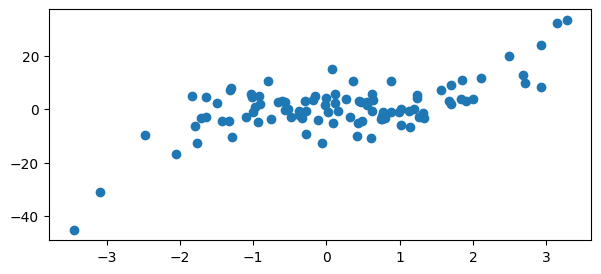

In [3]:
# Sample data (for illustration)
np.random.seed(1)  # For reproducibility
n = 100
p = 3  # Number of features
X = 1.5 * np.random.randn(n, p)  # Example data matrix with p features
y = X[:, p-1]**3 - 1.0*X[:, p-1] + 5.0 * np.random.normal(0, 1, n)  # Non-monotone response variable

# Visualize the relevant _last_ feature.
# Note that it is not entirely monotone(!)
plt.figure(figsize=(7,3))
plt.scatter(X[:,p-1], y)
plt.show()

The numerics of BEST, in particular due to the monotonicity re-parametrization, is highly non-trivial. It helps a lot to scale the data in advance. This may always be inverse transformed.

In [4]:
# Standardize the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler(with_std=True)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

We will use P-splines, that are B-splines with a very nice (sparse) difference penalty matrix. This has important "nice" computational properties. And, they are easy to define. The theory always talk about evenly spaced knots. Not knots at quantiles. At least from what I have seen.

In [5]:
# Define B-spline basis functions with evenly spaced knots
def create_bspline_basis(x, k=10, degree=3):
    x_min, x_max = np.min(x), np.max(x)
    knots = np.linspace(x_min, x_max, k + 2)  # Evenly spaced knots
    knots = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))  # Extend knots for spline degree
    return BSpline(knots, np.eye(len(knots) - degree - 1), degree)

Setting a "high" number of evenly spaced knots.
The high number is set to illustrate the adapt-to-noise problem. And need for penalization.
Using theory from Claeskens 2009, (see also Wood 2020) we only require $n^{\frac{1}{5}}$, because statistical error dominates function estimation error.

We could enforce different number of knots for the monotone, but here I do not.

In [6]:
def num_knots(j, p):
    k = 20 #int(np.ceil(n**(1./5)))  # Based on result from Claeskens 2009 -- statistical error dominates function error
    k_monotone = k
    return k_monotone if j == p - 1 else k

From e.g. Wood 2020: we are free to choose the degree of spline, and degree of difference.
Standard choices are 3 for spline degree and 2 for difference degree in penalization.

The commong smoothing matrix is defined for P-splines below.

In [7]:
degree = 3  # Degree of the spline
X_basis = [create_bspline_basis(X_scaled[:, j], k=num_knots(j, p), degree=degree)(X_scaled[:, j]) for j in range(p)]
X_expanded = np.hstack(X_basis)
nbasis = X_basis[0].shape[1]
nbasis_mono = X_basis[p - 1].shape[1]
print(nbasis)
print(nbasis_mono)

# Define the smoothing matrix S
def create_smoothing_matrix(nbasis):
    """For p-splines https://stats.stackexchange.com/questions/512045/generalized-additive-models-what-exactly-is-being-penalized-when-using-a-p-spli"""
    D = np.diff(np.eye(nbasis), n=2) # n=2: the difference degree
    S = D @ D.T
    return S

24
24


The constrained penalization matrix is defined in Wood 2014

In [8]:
def create_constrained_smoothing_matrix(nbasis):
    P = np.zeros((nbasis-2, nbasis))
    for i in range(nbasis-2):
        P[i,i+1] = 1
        P[i,i+2] = -1
    return P.T @ P

We do some book-keeping for the penalization matrices, and prepare to multiply with the $\lambda_j$

In [9]:
# Un-constrained / transformed parameters
S_list = [create_smoothing_matrix(X_basis[j].shape[1]) for j in range(p-1)]

# Monotonicity constraint: Wood 2014
S_list.append(create_constrained_smoothing_matrix(X_basis[p-1].shape[1]))
              
for S in S_list:
    print(S.shape)
S_block = np.block([[S_list[i] if i == j else np.zeros((S_list[i].shape[0], S_list[j].shape[0])) for j in range(p)] for i in range(p)])
print(f"S_block shape: {S_block.shape}, X_expanded shape: {X_expanded.shape}")

# Define S_block_lambda using JAX-compatible operations
def S_block_lambda(S_list, lambdas_smooth):
    assert len(lambdas_smooth) == len(S_list), "S_list and lambdas_smooth must be of same length"
    blocks = [lambdas_smooth[i] * S_list[i] for i in range(len(S_list))]
    return block_diag(*blocks)

(24, 24)
(24, 24)
(24, 24)
S_block shape: (72, 72), X_expanded shape: (100, 72)


The re-parametrization is as in Wood 2014. Perhaps this is the same as used by in triangular transport?

In [10]:
# Re-parametrize coefficients to ensure monotonicity
def reparametrize(beta_increments):
    #return beta_increments
    increments_transformed = jnp.array([beta_increments[0]] + list(jnp.exp(beta_increments)[1:]))
    return jnp.cumsum(increments_transformed)

We defined the joint negative log-likelihood of the data with a prior on $\lambda$.
This is the relevant part of

- $p(y|X, \lambda)$
- $p(\lambda)$ Note that this is de-generate. The normalization constant have a comment. The issue is not discussed in Wood 2020.
- Sum-to-zero constraint. It does not affect optimizing the subsequent Laplace approximation, I think.

In [11]:
# Define the objective function for MSE with smoothing penalty
def nll_joint(param, X_basis, y, lambda_smooth, S_list):    
    beta_init = jnp.array(param[:-1])
    log_sigma = param[-1]
    sigma2 = jnp.exp(2.0 * log_sigma)
    
    n = y.shape[0]
    X = jnp.hstack(X_basis)
    beta = beta_init.copy()
    beta = beta.at[-nbasis_mono:].set(reparametrize(beta[-nbasis_mono:]))
    
    y_pred = X @ beta
    mse = jnp.sum((y - y_pred)**2)
    nll = 0.5 * n * jnp.log(sigma2) + 0.5 * mse / sigma2

    #S_block_penalized = lambda_smooth * S_block
    S_block_penalized = S_block_lambda(S_list, lambda_smooth)
    smooth_penalty = 0.5 * beta_init.T @ S_block_penalized @ beta_init # - 0.5 * S_block.shape[0] * jnp.log(lambda_smooth)
    # normalization factor: average likelihood, ref TMB line 138 https://github.com/skaug/tmb-case-studies/blob/master/pSplines/pSplines.Rmd
    # - The part $0.5m_i\log(\lambda_i)$ is comming from the normalizing constant of the multivariate mean Gaussian distribution.
    # non trivial, as degenerate
    for i, lambda_i in enumerate(lambda_smooth):
        smooth_penalty -= 0.5 * S_list[i].shape[0] * jnp.log(lambda_i)

    sum_to_zero_penalty = 0
    for j in range(p):
        bj = beta[nbasis*j:nbasis*(j+1)]
        Xj = X_basis[j]
        sum_to_zero_penalty += 0.5 * bj.T @ Xj.T @ jnp.ones(n).reshape(-1,1) @ jnp.ones(n).reshape(1,-1) @ Xj @ bj
    
    return nll + smooth_penalty + sum_to_zero_penalty

We use `JAX` to easily compute derivative information using autodiff.
This is computationally efficient, and much less error prone than implementation by hand.

In [12]:
# Define the gradient and Hessian using JAX
nll_joint_jit = jit(nll_joint)
gradient_nll_joint = jit(grad(nll_joint))
hessian_nll_joint = jit(hessian(nll_joint))

# Convert the gradient and hessian functions to work with numpy arrays
def gradient_nll_joint_np(param, *args):
    return np.array(gradient_nll_joint(param, *args))

def hessian_nll_joint_np(param, *args):
    return np.array(hessian_nll_joint(param, *args))

Let's try to optimize the inner problem, conditioned on some small values of $\lambda$, thus almost no penalization.
Having experimented with different optimization algorithms. The BFGS seem very robust. It is important to set tolerance relatively low, even if it says we do not converge. This affects the numerical properties of the subsequent Laplace approximation.

In [13]:
# Initialize parameters
beta_initial = np.zeros(X_expanded.shape[1])
log_sigma_initial = 0.0  # np.log(np.var(y_scaled))
param_initial = np.append(beta_initial, log_sigma_initial)
print(f"log sigma init: {log_sigma_initial}")

# Perform the optimization with the gradient
lambda_smooth = [0.01, 0.01, 0.0001]
result = minimize(
    nll_joint_jit, 
    param_initial, 
    args=(X_basis, y_scaled, lambda_smooth, S_list), 
    jac=gradient_nll_joint_np, 
    hess=hessian_nll_joint_np, # Hessian is not stable under reparametrization
    #method="trust-ncg",
    #method="Newton-CG",
    #method="dogleg",
    tol=1e-9,
    options={"maxiter": 10000},
)
print(result)

# Extract the optimized beta coefficients
param_optimized = result.x.copy()
log_sigma_optimized = result.x[-1]
print(f"log-sigma optimized: {log_sigma_optimized}")

log sigma init: 0.0


/var/folders/cc/tr9zz8jx42d69801p14v77l00000gp/T/ipykernel_73270/3989124443.py:9: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 164.8455047607422
        x: [-9.562e-01  8.900e-01 ...  8.118e-01 -1.086e+00]
      nit: 661
      jac: [ 2.352e-04 -8.617e-06 ... -1.520e-02  9.588e-04]
 hess_inv: [[ 5.854e-01  3.938e-01 ... -2.151e-02  1.777e-03]
            [ 3.938e-01  5.607e+01 ... -2.373e-02  6.819e-03]
            ...
            [-2.151e-02 -2.373e-02 ...  1.351e-01 -5.222e-04]
            [ 1.777e-03  6.819e-03 ... -5.222e-04  4.416e-03]]
     nfev: 809
     njev: 797
log-sigma optimized: -1.0862594214281913


In [14]:
# Extract the optimized beta coefficients
beta_optimized = result.x.copy()[:-1]
beta_optimized[-nbasis_mono:] = reparametrize(beta_optimized[-nbasis_mono:])
log_sigma_optimized = result.x[-1]
print(f"sigma opt: {np.exp(log_sigma_optimized)}")

sigma opt: 0.33747649301263216


Let's plot our predictions. Hopefully we have adapted a lot to the noise. This is the problem we will solve. Note the estimate of $\sigma$. It is quite low, compared to the population value of $\sigma=5.0 / scale$ in the simulation and then standardization. This indicates adaptation to noise. A good solution will output a $\sigma$ estimate close to this value.

We would expct the $\sigma$ estimate to be close to

In [15]:
5.0 / scaler_y.scale_[0]

0.515639473774426

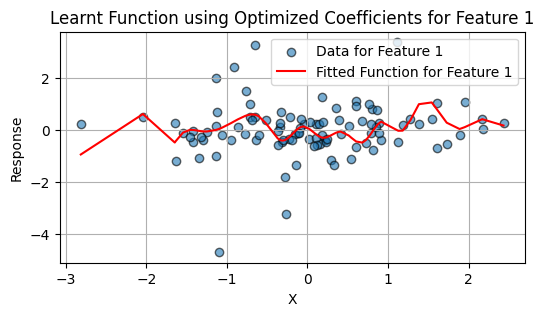

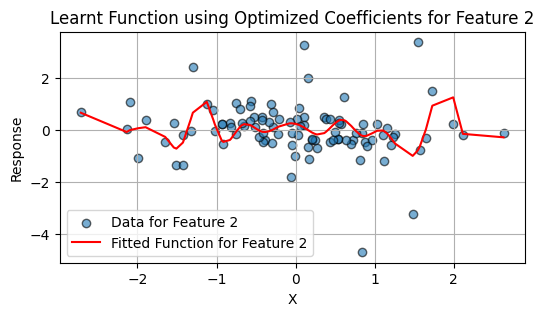

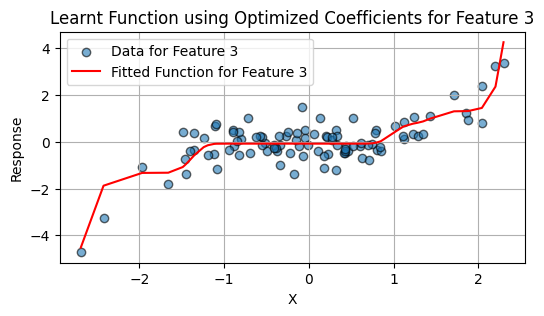

3.9323697369111205e-10
1.8733603157508692e-10
1.0091243726730037e-05
max gradient: 0.002737894654273987


In [16]:
# Evaluate the fitted function
def evaluate_smooth_function(X, beta, k=10, degree=3):
    X_basis = [create_bspline_basis(X[:, j], k=num_knots(j, p), degree=degree)(X[:, j]) for j in range(p)]
    X_expanded = np.hstack(X_basis)
    return X_expanded.dot(beta)

# Plotting
def evaluate_j_last_smooth(Xj, beta, j, k=10, degree=3):
    X_basis_j = create_bspline_basis(Xj, k=num_knots(j, p), degree=degree)(Xj)
    if j < p - 1:
        return X_basis_j.dot(beta[nbasis * j:nbasis * (j + 1)])
    else:
        return X_basis_j.dot(beta[-nbasis_mono:])

for j in range(p):
    plt.figure(figsize=(6, 3))
    y_pred_j = evaluate_j_last_smooth(X_scaled[:, j], beta_optimized, j, k=num_knots(j, p), degree=degree)
    plt.scatter(X_scaled[:, j], y_scaled, alpha=0.6, edgecolor='k', label=f'Data for Feature {j+1}')
    # for plotting line
    sorted_indices = np.argsort(X_scaled[:, j])
    Xj_sorted = X_scaled[sorted_indices, j]
    y_pred_sorted = y_pred_j[sorted_indices]
    plt.plot(Xj_sorted, y_pred_sorted, color='red', label=f'Fitted Function for Feature {j+1}')
    plt.title(f'Learnt Function using Optimized Coefficients for Feature {j+1}')
    plt.xlabel('X')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.show()

for j in range(p):
    bj = beta_optimized[nbasis*j:nbasis*(j+1)]
    Xj = X_basis[j]
    sum_to_zero_penalty = bj.T @ Xj.T @ np.ones(n).reshape(-1,1) @ np.ones(n).reshape(1,-1) @ Xj @ bj
    print(sum_to_zero_penalty)

print(f"max gradient: {np.max(result.jac)}")

We require the Hessian to be SPD. Due to numerical issues, it is not always. This is discussed by Wood 2020 and Wood 2014. Perturbation is then necessary.

Here I first find the closest semidefinite matrix in Frobenius norm (set eigenvalues $<0$ to zero). To find a "close" positive definite matrix, set all eiganvalues $<\epsilon$ to $\epsilon > 0$. One may also add a small positive element to all diagonal elements.

In [17]:
def closest_positive_semidefinite(H, eps=1e-1):
    """If eps=0, it is closest PSD. when eps>0 it is pd"""
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    
    # Set any negative eigenvalues to zero
    eigenvalues[eigenvalues <= eps] = eps
    
    # Reconstruct the matrix
    H_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    return H_psd + eps * np.eye(H_psd.shape[0])

See the TMB paper of Kristensen 2014 for details on the Laplace approximation and automatic differentiation.

In [18]:
# Define the negative log-likelihood Laplace approximation function
def neg_log_laplace(log_lambda, X_basis, y_scaled, S_list, eps=1e-1, return_beta=False, verbose=False):
    # Reparametrize to lambda
    lambda_smooth = jnp.exp(log_lambda)#.ravel()[0]

    if verbose:
        print(f"Current lambda: {lambda_smooth}")

    # Use current_beta_optimized if available, otherwise use the initial guess
    beta_initial = np.zeros(X_expanded.shape[1])
    log_sigma_initial = 0.0
    param_initial = np.append(beta_initial, log_sigma_initial)

    # Find the model of joint likelihood
    nll_joint_opt = minimize(
        nll_joint_jit, 
        param_initial, 
        args=(X_basis, y_scaled, lambda_smooth, S_list), 
        jac=gradient_nll_joint_np, 
        #hess=hessian_nll_joint_np,
        #method="Newton-CG",
        tol=1e-12,
        #options={"maxiter": 10000},
    )
    beta_optimized = np.array(nll_joint_opt.x[:-1])
    log_sigma_optimized = nll_joint_opt.x[-1]

    H = hessian_nll_joint_np(nll_joint_opt.x, X_basis, y_scaled, lambda_smooth, S_list)
    H_pd = closest_positive_semidefinite(H, eps=eps)
    log_det_H = cholesky(sp.csc_matrix(H_pd)).logdet()

    laplace_marginal = 0.5 * log_det_H + nll_joint_opt.fun

    if verbose:
        print(f"Inner optimization success: {nll_joint_opt.success}")
        print(f"Joint nll: {nll_joint_opt.fun}")
        print(f"sigma optimized: {np.exp(log_sigma_optimized)}")
        print(f"log-det Hessian: {log_det_H}  \n")


    if return_beta:
        return laplace_marginal, beta_optimized
    else:
        return laplace_marginal

Let's profile the Laplace approximation to the marginal likelihood w.r.t. $\lambda$, and see if we may find an optimum for the $\lambda_p$ for the significant feature.

In [19]:
# Profile the function over a range of log_lambda values
log_lambda_unconstrained_unimportant = 5 # we know these are unimportant, set high to inspect for the predicitve feature
log_lambdas_constrained_eval = np.linspace(-4,4, 20)
log_sigma = np.log(5.0)
laplace_res = [neg_log_laplace(
    np.array([log_lambda_unconstrained_unimportant, log_lambda_unconstrained_unimportant, log_lambda]),
    X_basis, 
    y_scaled, 
    S_list, 
    eps=1e-1
) for log_lambda in log_lambdas_constrained_eval]

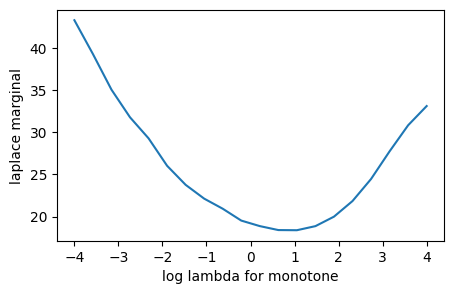

In [20]:
plt.figure(figsize=(5,3))
plt.plot(log_lambdas_constrained_eval, [val for val in laplace_res])
plt.xlabel("log lambda for monotone")
plt.ylabel("laplace marginal")
plt.show()

Now let's do direct optimization on all three lambdas.
This can be hard for the optimizer. Note that the TMB paper also discuss gradient of the Laplace objective. This could help with convergence. I have also bloged about this before, see the table: https://berentlunde.netlify.app/post/tmb-and-the-saddlepoint-approximation/

Because monotonicity constraint enforces quite a lot of regularization. The initial $\lambda$ for the last feature may be a lot smaller.

In [21]:
# Initial guess for log(lambda)
log_lambdas_unconstr_init = 2.0
log_lambdas_constr_init = - 2.0

# Perform the optimization on log(lambda)
result = minimize(
    neg_log_laplace, 
    [log_lambdas_unconstr_init, log_lambdas_unconstr_init, log_lambdas_constr_init],
    args=(X_basis, y_scaled, S_list, 1e-1),
    method="Nelder-Mead",
    bounds=[(-5, 5)]
)

print("Optimization result:")
print(result)

Optimization result:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 18.593502937123418
             x: [ 4.989e+00  4.813e+00  6.170e-01]
           nit: 84
          nfev: 201
 final_simplex: (array([[ 4.989e+00,  4.813e+00,  6.170e-01],
                       [ 4.989e+00,  4.813e+00,  6.170e-01],
                       [ 4.989e+00,  4.813e+00,  6.170e-01],
                       [ 4.989e+00,  4.813e+00,  6.170e-01]]), array([ 1.859e+01,  1.859e+01,  1.859e+01,  1.859e+01]))


In [22]:
lambda_opt = np.exp(result.x)
print(f"param opt: {np.exp(result.x)}")

param opt: [146.82328976 123.11473224   1.85340488]


Notice 
- The smooth function
- The estimate for $\sigma$, which should be close to

In [23]:
5.0 / scaler_y.scale_[0]

0.515639473774426

Current lambda: [146.82327   123.114716    1.8534049]
Inner optimization success: False
Joint nll: -138.35574340820312
sigma optimized: 0.5059994951835026
log-det Hessian: 313.8984926906531  



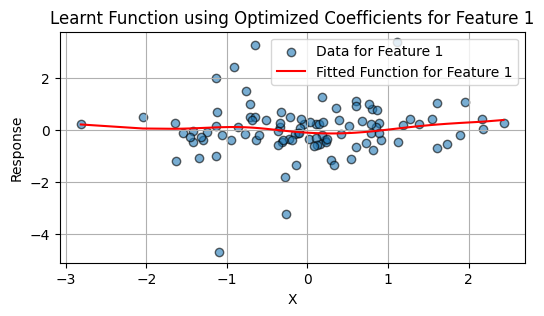

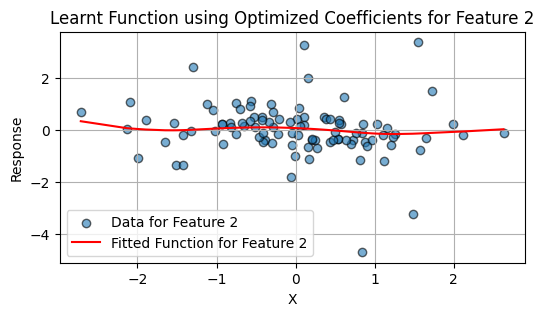

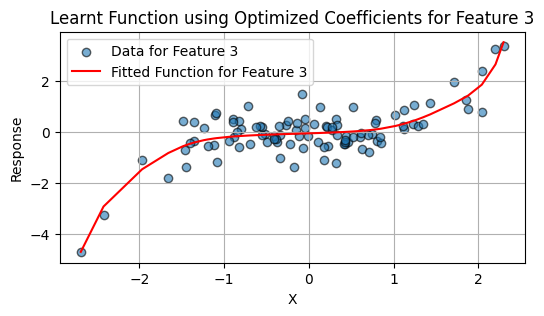

In [24]:
_, beta_opt = neg_log_laplace(result.x, X_basis, y_scaled, S_list, 1e-1, return_beta=True, verbose=True)
beta_opt[-nbasis_mono:] = reparametrize(beta_opt[-nbasis_mono:])


# Evaluate the fitted function
def evaluate_smooth_function(X, beta, k=10, degree=3):
    X_basis = [create_bspline_basis(X[:, j], k=num_knots(j, p), degree=degree)(X[:, j]) for j in range(p)]
    X_expanded = np.hstack(X_basis)
    return X_expanded.dot(beta)

# Plotting
def evaluate_j_last_smooth(Xj, beta, j, k=10, degree=3):
    X_basis_j = create_bspline_basis(Xj, k=num_knots(j, p), degree=degree)(Xj)
    if j < p - 1:
        return X_basis_j.dot(beta[nbasis * j:nbasis * (j + 1)])
    else:
        return X_basis_j.dot(beta[-nbasis_mono:])

for j in range(p):
    plt.figure(figsize=(6, 3))
    y_pred_j = evaluate_j_last_smooth(X_scaled[:, j], beta_opt, j, k=num_knots(j, p), degree=degree)
    plt.scatter(X_scaled[:, j], y_scaled, alpha=0.6, edgecolor='k', label=f'Data for Feature {j+1}')
    # for plotting line
    sorted_indices = np.argsort(X_scaled[:, j])
    Xj_sorted = X_scaled[sorted_indices, j]
    y_pred_sorted = y_pred_j[sorted_indices]
    plt.plot(Xj_sorted, y_pred_sorted, color='red', label=f'Fitted Function for Feature {j+1}')
    plt.title(f'Learnt Function using Optimized Coefficients for Feature {j+1}')
    plt.xlabel('X')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.show()

# Application to the wavy problem

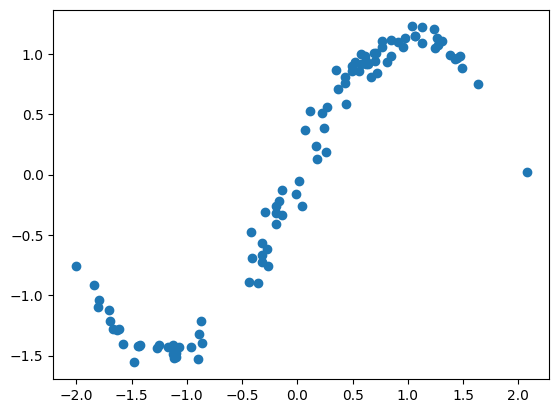

In [584]:
import scipy.stats

def sample_wavy_distribution(size):
    # First draw some rotation samples from a beta distribution, then scale
    # them to the range between -pi and +2pi
    seeds = scipy.stats.beta.rvs(
        a       = 2,
        b       = 2,
        size    = size)*2*np.pi-1*np.pi

    # Plot the rotation samples on a straight spiral
    X       = np.column_stack((
        seeds[:,np.newaxis],
        np.sin(seeds)[:,np.newaxis]))#*((1+seeds+np.pi)/(3*np.pi)*5)[:,np.newaxis]
    
    # X   += (scipy.stats.norm.rvs(size=size)*scipy.stats.norm.pdf(seeds))[:,np.newaxis]
    
    # Offset each sample along the spiral's normal vector by scaled Gaussian
    # noise
    # Normal is (-dy,dx)
    # (dx,dy) of sin curve is (1,np.cos(seeds))
    X   += np.column_stack([
        -np.cos(seeds)/np.sqrt(np.cos(seeds)**2 + 1),
        np.sqrt(np.cos(seeds)**2 + 1)])*(scipy.stats.norm.rvs(scale=0.3,size=size)*scipy.stats.norm.pdf(seeds,scale=2))[:,np.newaxis]
    X[:,0] /= 1.5
    X[:,1] *= 1.5
    return X

p=2
n = 100
X = sample_wavy_distribution(n)

# Standardize the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
plt.scatter(X_scaled[:,0],X_scaled[:,1])
plt.show()

In [585]:
# Define B-spline basis functions with knots at quantiles
def create_bspline_basis(x, k=10, degree=3):
    quantiles = np.linspace(0, 1, k + 2)  # Define quantiles
    knots = np.quantile(x, quantiles)  # Calculate knots at quantiles
    knots = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))  # Extend knots for spline degree
    return BSpline(knots, np.eye(len(knots) - degree - 1), degree)

degree = 3
k = int(np.ceil(n**(1./3)))
Bx = [create_bspline_basis(X_scaled[:,j], k=k, degree=degree) for j in range(p)]
X_basis = [Bx[j](X_scaled[:,j]) for j in range(p)]
X_expanded = np.hstack(X_basis)
nbasis = X_basis[0].shape[1]
nbasis_mono = X_basis[p - 1].shape[1]
print(nbasis, nbasis_mono)

9 9


It seems that a direct frequentist approach with an AIC-type criterion is computationally easier.
Also, it seems sum-to-zero constraints should be enforced through parametrization, and not through a penalty. It leads to noisy values in $\lambda$.

In [456]:
def nll(beta_init, X_basis, dBxj):
    X_full = jnp.hstack(X_basis)
    beta_reparam = beta_init.copy()
    beta_reparam = beta_reparam.at[-nbasis_mono:].set(reparametrize(beta_reparam[-nbasis_mono:]))
    Sx = X_full @ beta_reparam
    dSxj = dBxj @ beta_reparam[-nbasis_mono:]
    return 0.5 * jnp.sum(Sx**2) - jnp.sum(jnp.log(dSxj))


def nll_penalized(beta_init, X_basis, lambda_smooth, S_list, dBxj):
    # Only the penalty is needed when working with beta as M-estimators
    S_block_penalized = S_block_lambda(S_list, lambda_smooth)
    smooth_penalty = 0.5 * beta_init.T @ S_block_penalized @ beta_init # - 0.5 * S_block.shape[0] * jnp.log(lambda_smooth)
    return nll(beta_init, X_basis, dBxj) + smooth_penalty

# Define the gradient and Hessian using JAX
nll_jit = jit(nll)
gradient_nll = jit(grad(nll))
hessian_nll = jit(hessian(nll))

# Define the gradient and Hessian using JAX
nll_penalized_jit = jit(nll_penalized)
gradient_nll_penalized = jit(grad(nll_penalized))
hessian_nll_penalized = jit(hessian(nll_penalized))

Create the information criterion, and then a function that approximates evaluations on test data.

In [457]:
def diff_test_train(beta_opt, X_basis, lambda_smooth, S_list, dBxj):
    H_pen = hessian_nll_penalized(beta_opt, X_basis, lambda_smooth, S_list, dBxj)
    H_nll = hessian_nll(beta_opt, X_basis, dBxj)
    aic = np.trace(np.linalg.pinv(H_pen) @ H_nll)
    return aic

def test_lambda(log_lambda, X_basis, S_list, dBxj, return_beta=False):

    lambda_smooth = jnp.exp(log_lambda)
    beta_initial = np.zeros(len(X_basis) * nbasis_mono)

    nll_opt = minimize(
        nll_penalized_jit, 
        beta_initial, 
        args=(X_basis, lambda_smooth, S_list, dBxj), 
        jac=gradient_nll_penalized, 
        hess=hessian_nll_penalized,
        method="Newton-CG",
        tol=1e-9,
        #options={"maxiter": 10000},
    )

    if return_beta:
        return nll_opt.fun + diff_test_train(nll_opt.x, X_basis, lambda_smooth, S_list, dBxj), nll_opt.x
    else:
        return nll_opt.fun + diff_test_train(nll_opt.x, X_basis, lambda_smooth, S_list, dBxj)

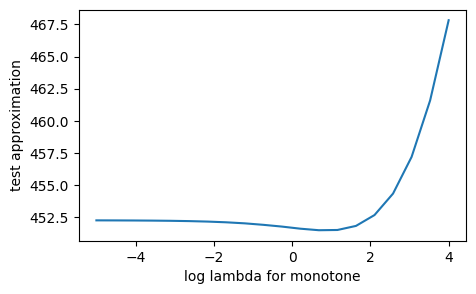

In [458]:
S_list = [create_constrained_smoothing_matrix(nbasis)]
dBxj = Bx[0].derivative()(X_scaled[:,0])

# Profile the function over a range of log_lambda values
log_lambda_unconstrained_unimportant = 5 # we know these are unimportant, set high to inspect for the predicitve feature
log_lambdas_constrained_eval = np.linspace(-5,4, 20)

test_res = [test_lambda(
    np.array([log_lambda]),
    X_basis[:1],
    S_list,
    dBxj,
) for log_lambda in log_lambdas_constrained_eval]

plt.figure(figsize=(5,3))
plt.plot(log_lambdas_constrained_eval, [val for val in test_res])
plt.xlabel("log lambda for monotone")
plt.ylabel("test approximation")
plt.show()

Everything seems good. Let's optimize our two functions in the KR map.

In [459]:
S_list1 = [create_constrained_smoothing_matrix(nbasis)]
dBxj = Bx[0].derivative()(X_scaled[:,0])

lambda_1_opt = minimize(
    test_lambda, 
    [2.0],
    args=(
        X_basis[:1],
        S_list1,
        dBxj,    
    ),
    method="Nelder-Mead",
)

print("Optimization result:")
print(lambda_1_opt)
_, beta1 = test_lambda(lambda_1_opt.x, X_basis[:1], S_list1, dBxj, return_beta=True)

Optimization result:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 451.47178745269775
             x: [ 8.789e-01]
           nit: 28
          nfev: 66
 final_simplex: (array([[ 8.789e-01],
                       [ 8.789e-01]]), array([ 4.515e+02,  4.515e+02]))


In [460]:
S_list2 = [
    create_smoothing_matrix(nbasis),
    create_constrained_smoothing_matrix(nbasis)
]
dBxj = Bx[1].derivative()(X_scaled[:,1])

lambda_2_opt = minimize(
    test_lambda, 
    [2.0, 2.0],
    args=(
        X_basis[:2],
        S_list2,
        dBxj,    
    ),
    method="Nelder-Mead",
)

print("Optimization result:")
print(lambda_2_opt)
_, beta2 = test_lambda(lambda_2_opt.x, X_basis[:2], S_list2, dBxj, return_beta=True)

Optimization result:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1763.2394495010376
             x: [-8.961e+00  4.005e+00]
           nit: 55
          nfev: 134
 final_simplex: (array([[-8.961e+00,  4.005e+00],
                       [-8.961e+00,  4.005e+00],
                       [-8.961e+00,  4.005e+00]]), array([-1.763e+03, -1.763e+03, -1.763e+03]))


Use $S(x)$ to map to 2-D standard normal (approximately).

In [461]:
lambda1_val = lambda_1_opt.x # np.array([-1e1])
lambda2_val = lambda_2_opt.x # np.array([-1e1, -1e1])
#lambda1_val = np.array([-1e1])
#lambda2_val = np.array([-1e1, -1e1])
_, beta1 = test_lambda(lambda1_val, X_basis[:1], S_list1, dBxj, return_beta=True)
_, beta2 = test_lambda(lambda2_val, X_basis[:2], S_list2, dBxj, return_beta=True)

beta1[-nbasis_mono:] = reparametrize(beta1[-nbasis_mono:])
z1 = X_basis[0].dot(beta1)

beta2[-nbasis_mono:] = reparametrize(beta2[-nbasis_mono:])
z2 = np.hstack(X_basis).dot(beta2)

We now check that the marginals and the copula looks okay

In [462]:
# Create test data
X_te = sample_wavy_distribution(n)
X_te_scaled = scaler_X.transform(X_te)
X_basis_te = [Bx[j](X_te_scaled[:,j]) for j in range(2)]
z1_te = X_basis_te[0].dot(beta1)
z2_te = np.hstack(X_basis_te).dot(beta2)

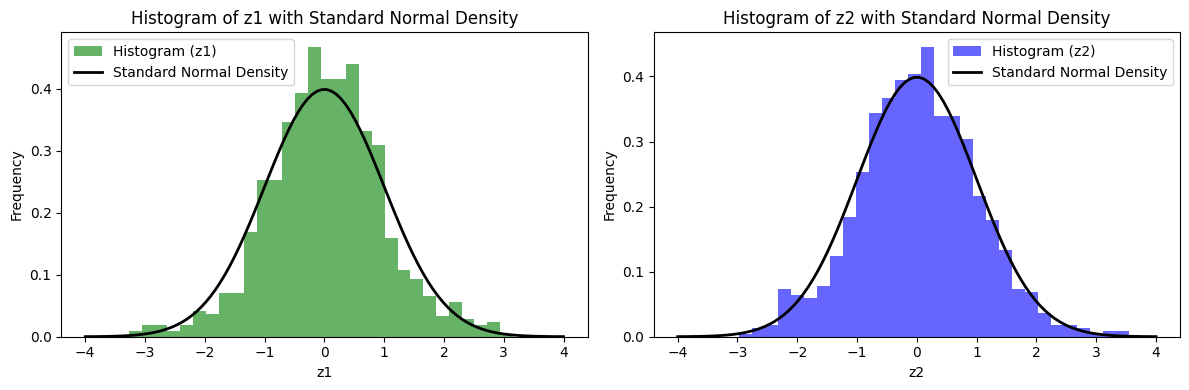

In [463]:
from scipy.stats import norm

x = np.linspace(-4, 4, 100)
y = norm.pdf(x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram and standard normal density for z1
axes[0].hist(z1_te, bins=30, density=True, alpha=0.6, color='g', label='Histogram (z1)')
axes[0].plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
axes[0].set_title("Histogram of z1 with Standard Normal Density")
axes[0].set_xlabel("z1")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Plot histogram and standard normal density for z2
axes[1].hist(z2_te, bins=30, density=True, alpha=0.6, color='b', label='Histogram (z2)')
axes[1].plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
axes[1].set_title("Histogram of z2 with Standard Normal Density")
axes[1].set_xlabel("z2")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

The above looks good, I think

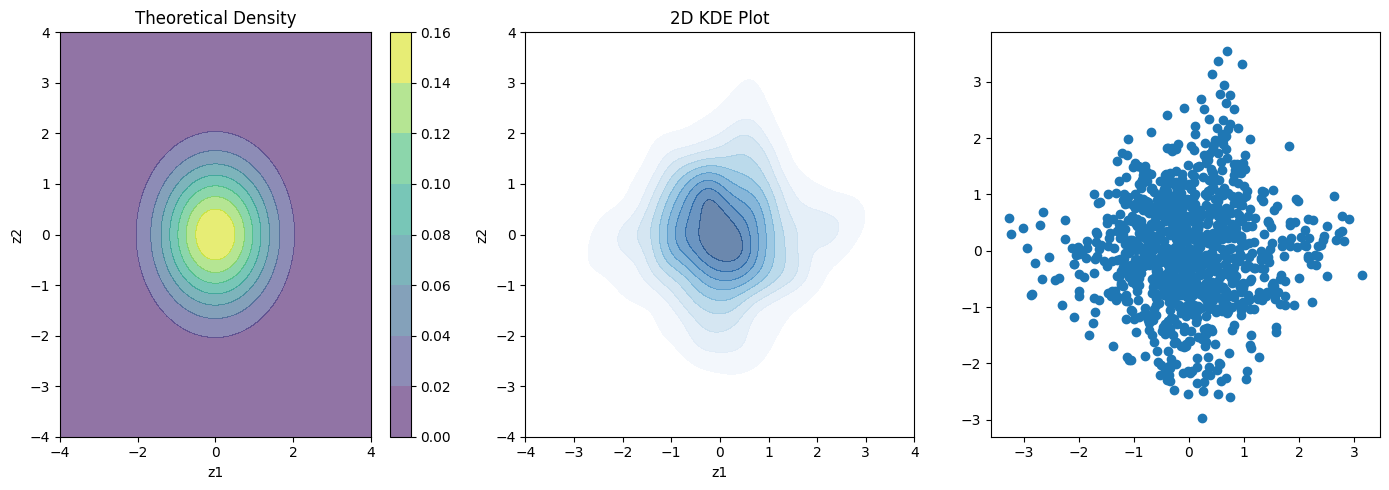

In [464]:
from scipy.stats import multivariate_normal
import seaborn as sns

# Define the grid for the plot
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()])

# Create the multivariate normal distribution
rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])

# Evaluate the density function at the grid points
Z = rv.pdf(positions.T).reshape(100, 100)

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# First subplot: Theoretical density
ax1 = axes[0]
c1 = ax1.contourf(X, Y, Z, cmap='viridis', alpha=0.6)
fig.colorbar(c1, ax=ax1)
ax1.set_title("Theoretical Density")
ax1.set_xlabel('z1')
ax1.set_ylabel('z2')
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

# Second subplot: 2D KDE plot
ax2 = axes[1]
sns.kdeplot(x=z1_te, y=z2_te, ax=ax2, cmap='Blues', fill=True, alpha=0.6)
ax2.set_title("2D KDE Plot")
ax2.set_xlabel('z1')
ax2.set_ylabel('z2')
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])

ax2 = axes[2]
ax2.scatter(z1_te, z2_te)

plt.tight_layout()
plt.show()

# Define the gradient of the outer objectie w.r.t. $\log(\lambda)$

In [617]:
def nll(beta_init, X_basis, dBxj):
    #print("running nll")
    if isinstance(X_basis, list):
        X_full = jnp.hstack(X_basis)
    else:
        X_full = X_basis
    beta_reparam = beta_init.copy()
    beta_reparam = beta_reparam.at[-nbasis_mono:].set(reparametrize(beta_reparam[-nbasis_mono:]))
    Sx = X_full @ beta_reparam
    dSxj = dBxj @ beta_reparam[-nbasis_mono:]
    return 0.5 * jnp.sum(Sx**2) - jnp.sum(jnp.log(dSxj))

def nll_penalized(beta_init, log_lambda, X_basis, S_list, dBxj):
    #print("running nll_penalized")
    lambda_smooth = jnp.exp(log_lambda)
    # Only the penalty is needed when working with beta as M-estimators
    S_block_penalized = S_block_lambda(S_list, lambda_smooth)
    smooth_penalty = 0.5 * beta_init.T @ S_block_penalized @ beta_init
    return nll(beta_init, X_basis, dBxj) + smooth_penalty

def nll_penalized_nu(nu, X_basis, S_list, dBxj):
    n_lambda = len(S_list)
    beta_init, log_lambda = nu[:-n_lambda], nu[-n_lambda:]
    return nll_penalized(beta_init, log_lambda, X_basis, S_list, dBxj)

# Define the gradient and Hessian using JAX
nll_jit = jit(nll)
gradient_nll = jit(grad(nll))
hessian_nll = jit(hessian(nll))

# Define the gradient and Hessian using JAX
nll_penalized_jit = jit(nll_penalized)
dfdbeta = jit(grad(nll_penalized))
ddfdbeta = jit(hessian(nll_penalized))
dfdnu = jit(grad(nll_penalized_nu))
ddfdnu = jit(hessian(nll_penalized_nu))

# Define AIC-type criterion and diff_test_train
def aic(beta, log_lambda, X_basis, S_list, dBxj):
    H_pen = ddfdbeta(beta, log_lambda, X_basis, S_list, dBxj)
    H_nll = hessian_nll(beta, X_basis, dBxj)
    aic = jnp.trace(jnp.linalg.pinv(H_pen) @ H_nll)
    return aic

aic_jit = jit(aic)

def h(beta, log_lambda, X_basis, S_list, dBxj):
    #print("running h")
    return nll_penalized_jit(beta, log_lambda, X_basis, S_list, dBxj) + aic_jit(beta, log_lambda, X_basis, S_list, dBxj)

h_jit = jit(h)
dhdnu = jit(grad(h, argnums=(0,1)))

# Define the outer objective function
def test_lambda(log_lambda, X_basis, S_list, dBxj, return_beta=False):
    beta_initial = jnp.zeros(len(X_basis) * nbasis_mono)

    nll_opt = minimize(
        nll_penalized_jit, 
        beta_initial, 
        args=(log_lambda, X_basis, S_list, dBxj), 
        jac=dfdbeta, 
        hess=ddfdbeta,
        method="Newton-CG",
        tol=1e-9,
    )
    if return_beta:
        return nll_opt.fun + aic_jit(nll_opt.x, log_lambda, X_basis, S_list, dBxj), nll_opt.x
    else:
        return nll_opt.fun + aic_jit(nll_opt.x, log_lambda, X_basis, S_list, dBxj)
    
def grad_test_lambda(log_lambda, X_basis, S_list, dBxj):
    nlambda = len(log_lambda)
    # Solve inner problem
    beta_initial = jnp.zeros(len(X_basis) * nbasis)
    f_opt = minimize(
        nll_penalized_jit, 
        beta_initial, 
        args=(log_lambda, X_basis, S_list, dBxj), 
        jac=dfdbeta, 
        hess=ddfdbeta,
        method="Newton-CG",
        tol=1e-9,
    )
    beta_opt = f_opt.x
    nbeta = len(beta_opt)
    dh_dnu = dhdnu(beta_opt, log_lambda, X_basis, S_list, dBxj)
    dh_dbeta = dh_dnu[0]
    dh_dloglambda = dh_dnu[1]

    nu = jnp.concatenate([beta_opt, log_lambda])
    H_pen = ddfdnu(nu, X_basis, S_list, dBxj)
    H_pen_beta = H_pen[:nbeta, :nbeta]
    H_pen_beta_lambda = H_pen[:nbeta, nbeta:]

    # Define gradient manually using IFT
    return dh_dloglambda - dh_dbeta.T @ jnp.linalg.pinv(H_pen_beta) @ H_pen_beta_lambda

# Sample data

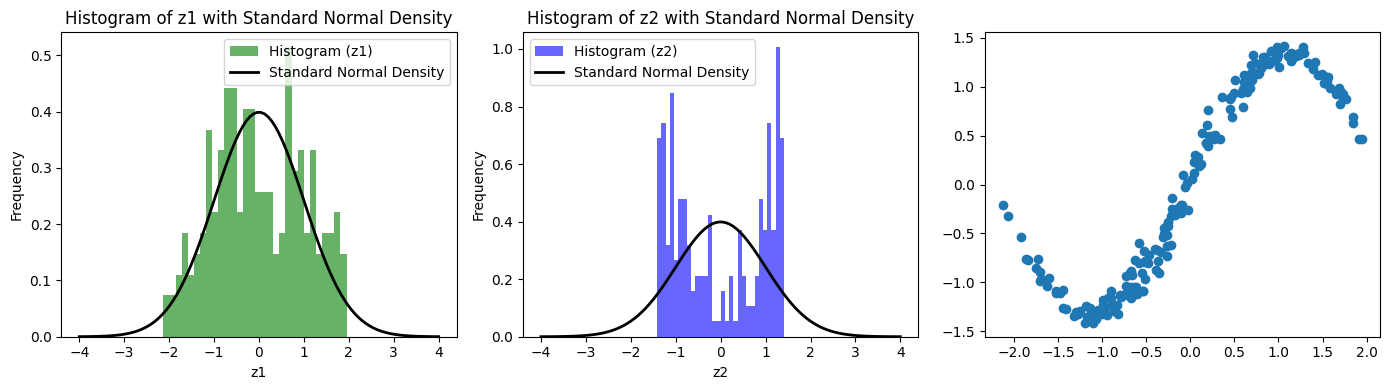

44 44


In [626]:
p=2
n = 200
X = sample_wavy_distribution(n)

# Standardize the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


x = np.linspace(-4, 4, 100)
y = norm.pdf(x)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# First subplot: Theoretical density
ax1 = axes[0]
# Create the figure and subplots
ax1.hist(X_scaled[:,0], bins=30, density=True, alpha=0.6, color='g', label='Histogram (z1)')
ax1.plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
ax1.set_title("Histogram of z1 with Standard Normal Density")
ax1.set_xlabel("z1")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2 = axes[1]
# Plot histogram and standard normal density for z2
ax2.hist(X_scaled[:,1], bins=30, density=True, alpha=0.6, color='b', label='Histogram (z2)')
ax2.plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
ax2.set_title("Histogram of z2 with Standard Normal Density")
ax2.set_xlabel("z2")
ax2.set_ylabel("Frequency")
ax2.legend()

ax3 = axes[2]
ax3.scatter(X_scaled[:,0],X_scaled[:,1])

plt.tight_layout()
plt.show()

# Define B-spline basis functions with knots at quantiles
def create_bspline_basis(x, k=10, degree=3):
    quantiles = np.linspace(0, 1, k + 2)  # Define quantiles
    knots = np.quantile(x, quantiles)  # Calculate knots at quantiles
    knots = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))  # Extend knots for spline degree
    return BSpline(knots, np.eye(len(knots) - degree - 1), degree)

degree = 3
k = 10 #int(np.ceil(n**(1./3)))
Bx = [create_bspline_basis(X_scaled[:,j], k=k, degree=degree) for j in range(p)]
X_basis = [Bx[j](X_scaled[:,j]) for j in range(p)]
X_expanded = np.hstack(X_basis)
nbasis = X_basis[0].shape[1]
nbasis_mono = X_basis[p - 1].shape[1]
print(nbasis, nbasis_mono)

In [627]:
S_list1 = [create_constrained_smoothing_matrix(nbasis)]
dBxj = Bx[0].derivative()(X_scaled[:,0])

lambda_1_opt = minimize(
    test_lambda, 
    [2.0],
    args=(
        X_basis[:1],
        S_list1,
        dBxj,    
    ),
    jac=grad_test_lambda
    #method="Nelder-Mead",
)

print("Optimization result:")
print(lambda_1_opt)
_, beta1 = test_lambda(lambda_1_opt.x, X_basis[:1], S_list1, dBxj, return_beta=True)

S_list2 = [
    create_smoothing_matrix(nbasis),
    create_constrained_smoothing_matrix(nbasis)
]
dBxj = Bx[1].derivative()(X_scaled[:,1])

lambda_2_opt = minimize(
    test_lambda, 
    [2.0, 2.0],
    args=(
        X_basis[:2],
        S_list2,
        dBxj,    
    ),
    jac=grad_test_lambda,
    #method="Nelder-Mead",
)

print("Optimization result:")
print(lambda_2_opt)
_, beta2 = test_lambda(lambda_2_opt.x, X_basis[:2], S_list2, dBxj, return_beta=True)

Optimization result:
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 96.7786636352539
        x: [ 2.887e+00]
      nit: 4
      jac: [-3.710e-06]
 hess_inv: [[ 3.744e-01]]
     nfev: 23
     njev: 23
Optimization result:
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -367.593505859375
        x: [ 2.427e-01  3.343e+00]
      nit: 7
      jac: [-2.786e-03  5.730e-04]
 hess_inv: [[ 5.396e-01 -3.244e-02]
            [-3.244e-02  3.933e-01]]
     nfev: 43
     njev: 32


In [628]:
lambda1_val = lambda_1_opt.x # np.array([-1e1])
lambda2_val = lambda_2_opt.x # np.array([-1e1, -1e1])
#lambda1_val = np.array([-1e1])
#lambda2_val = np.array([-1e1, -1e1])
_, beta1 = test_lambda(lambda1_val, X_basis[:1], S_list1, dBxj, return_beta=True)
_, beta2 = test_lambda(lambda2_val, X_basis[:2], S_list2, dBxj, return_beta=True)

beta1[-nbasis_mono:] = reparametrize(beta1[-nbasis_mono:])
z1 = X_basis[0].dot(beta1)

beta2[-nbasis_mono:] = reparametrize(beta2[-nbasis_mono:])
z2 = np.hstack(X_basis).dot(beta2)

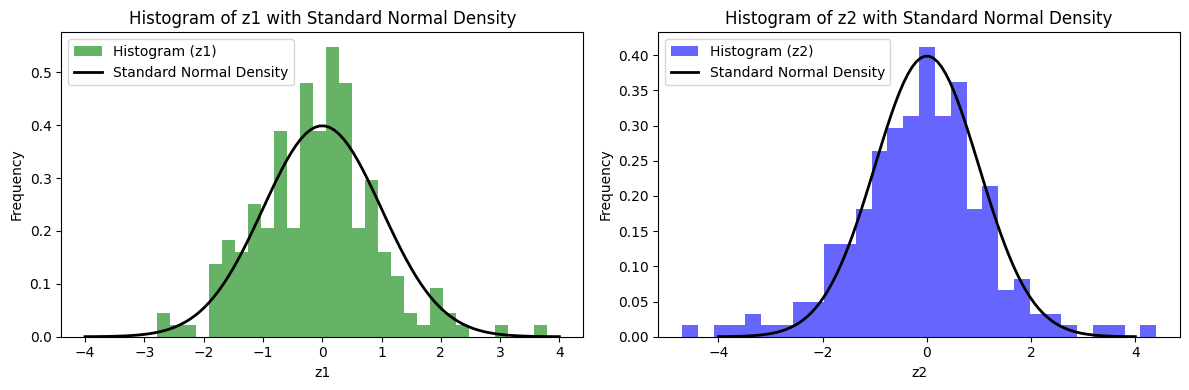

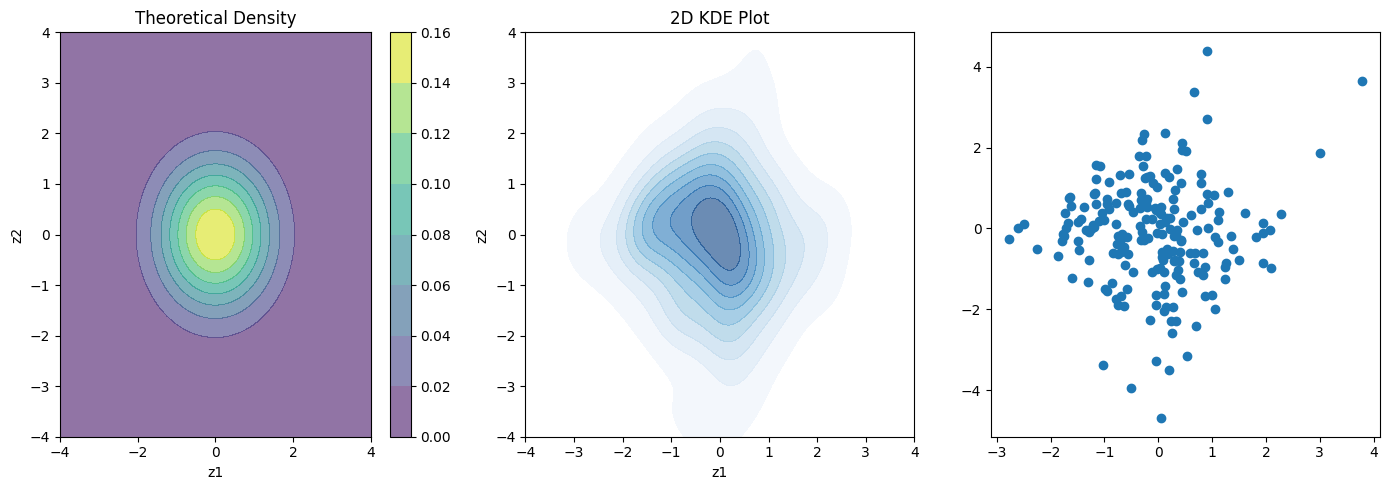

In [629]:
# Create test data
X_te = sample_wavy_distribution(n)
X_te_scaled = scaler_X.transform(X_te)
X_basis_te = [Bx[j](X_te_scaled[:,j]) for j in range(2)]
z1_te = X_basis_te[0].dot(beta1)
z2_te = np.hstack(X_basis_te).dot(beta2)

from scipy.stats import norm

x = np.linspace(-4, 4, 100)
y = norm.pdf(x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram and standard normal density for z1
axes[0].hist(z1_te, bins=30, density=True, alpha=0.6, color='g', label='Histogram (z1)')
axes[0].plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
axes[0].set_title("Histogram of z1 with Standard Normal Density")
axes[0].set_xlabel("z1")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Plot histogram and standard normal density for z2
axes[1].hist(z2_te, bins=30, density=True, alpha=0.6, color='b', label='Histogram (z2)')
axes[1].plot(x, y, 'k', linewidth=2, label='Standard Normal Density')
axes[1].set_title("Histogram of z2 with Standard Normal Density")
axes[1].set_xlabel("z2")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

from scipy.stats import multivariate_normal
import seaborn as sns

# Define the grid for the plot
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()])

# Create the multivariate normal distribution
rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])

# Evaluate the density function at the grid points
Z = rv.pdf(positions.T).reshape(100, 100)

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# First subplot: Theoretical density
ax1 = axes[0]
c1 = ax1.contourf(X, Y, Z, cmap='viridis', alpha=0.6)
fig.colorbar(c1, ax=ax1)
ax1.set_title("Theoretical Density")
ax1.set_xlabel('z1')
ax1.set_ylabel('z2')
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

# Second subplot: 2D KDE plot
ax2 = axes[1]
sns.kdeplot(x=z1_te, y=z2_te, ax=ax2, cmap='Blues', fill=True, alpha=0.6)
ax2.set_title("2D KDE Plot")
ax2.set_xlabel('z1')
ax2.set_ylabel('z2')
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])

ax2 = axes[2]
ax2.scatter(z1_te, z2_te)

plt.tight_layout()
plt.show()